In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from dotenv import load_dotenv
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
module_path = f"{project_root}/"
sys.path.insert(0, module_path)


In [2]:
import torch
import numpy as np
import torch
import torchvision.transforms as transforms
from tqdm import  tqdm
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from easydict import EasyDict
from torchvision.transforms import Compose

from utils import *
from classes import *
import seaborn as sns
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)
sns.set_palette(sns.color_palette("deep"))



Global seed set to 42


In [3]:
## Needs to be downscaled to support resnets dense layers, which require 224,224 image sizes
resnet_im_size = (224,224)
dataset_batch_size=64
should_shuffle_datasets = True
num_samples_per_class = 2048

data_root =  f"{project_root}/datasets/processing_datasets/first_iteration/"
large_root = f"{project_root}/datasets/processing_datasets/second_iteration/"
three_root = f"{project_root}/datasets/processing_datasets/third_iteration/"
fifty_root = f"{project_root}/datasets/final_datasets/benign/full_size"

img_transforms = Compose([
    transforms.Resize(resnet_im_size),
    transforms.ToTensor(),
    ])

int_labels, label_map = get_label_arr_and_map(
    torch_features=23
)


resnet_model = get_trained_resnet_model(
    layers=101,
    out_features=23,
    weight_str=f"{project_root}/weights/classifiers/first_iteration.pt"
)

if torch.cuda.is_available():
    resnet_model = resnet_model.cuda()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
benign_data = gen_classification_tvt_dict(
    data_root=f"{data_root}",
    batch_size=dataset_batch_size,
    should_shuffle_datasets=should_shuffle_datasets,
    transforms=img_transforms,
)

In [5]:
eval_dataset = benign_data.test
resnet_model.eval()
report = EasyDict(nb_test=0, correct=0)
predictions = torch.zeros(23,23)
for x, y in tqdm(eval_dataset, position=0,leave=True):
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        preds = torch.argmax(resnet_model(x),dim=1)
        
        for p, gt in zip(preds, y):
            predictions[gt.item()][p.item()] += 1

100%|██████████| 2918/2918 [07:45<00:00,  6.26it/s]


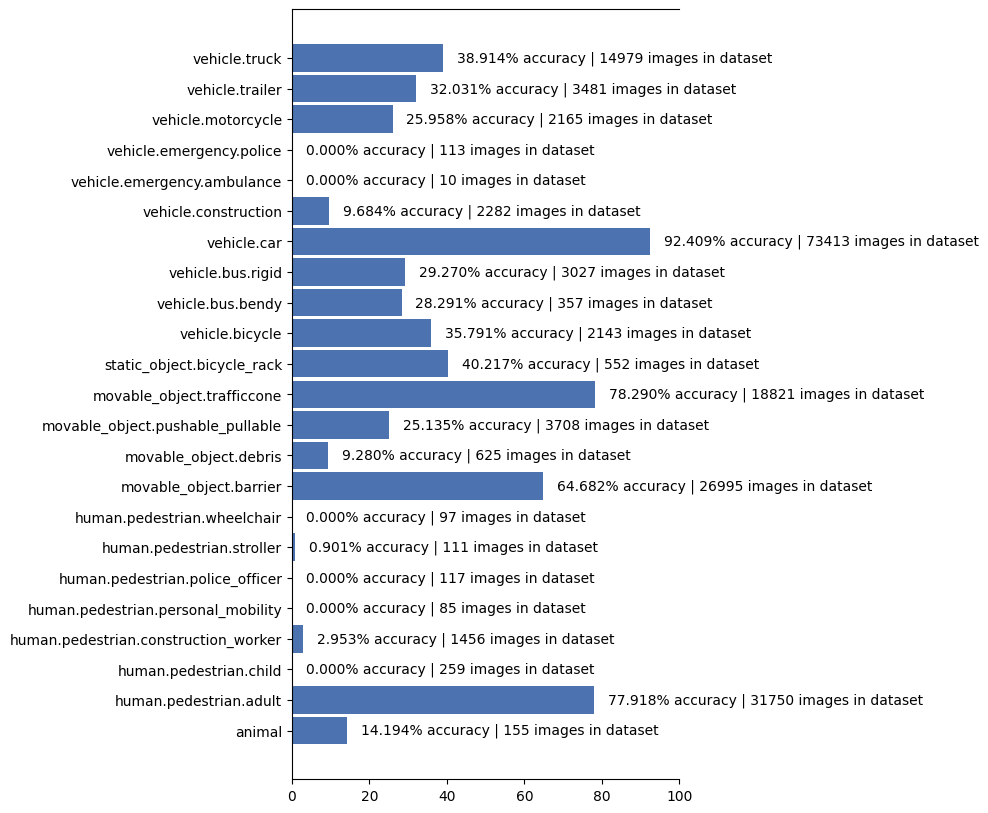

In [6]:

fig, ax = plt.subplots(figsize=(5,10))

plt.xticks(rotation=0)

pred_numpy = predictions.numpy()

sum_preds = pred_numpy.sum(axis=1)

self_preds = np.array([x[i] for i,x in zip(range(0,24),pred_numpy)])

acc_preds = np.divide(self_preds,sum_preds)*100

bar_width = 1.8
bar_y_coords = range(0,46,2)
ax.set_yticks(
    bar_y_coords,
    labels=int_labels
    )


acc_bar = ax.barh(
    y=[x-bar_width/2 for x in bar_y_coords],
    width=[x for x in  acc_preds],
    height=bar_width,
    align="edge",
    
)



ax.bar_label(
    container=acc_bar,
    labels=["%.3f%% accuracy | %g images in dataset" % (x, samples) for x,samples in zip(acc_preds,sum_preds)],
    label_type="edge",
    padding=10
    
)


ax.spines["right"].set_visible(False)


ax.set_xlim(
    0,100
)

plt.savefig(
    fname=f"{project_root}/plots/dataset_23_accuracy.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_23_accuracy.svg",
     bbox_inches = 'tight'
)

print()

In [7]:
plt.rcParams.update({'font.size': 30, "font.weight":"normal"})
def generate_subplot(axis, preds,labels,num_incorrect_class_shown,int_labels ):

    ax2 = axis.twiny()
    
    predictions = np.copy(preds)

    ## Sets the number of predictions of itself to zero. 
    np.fill_diagonal(predictions,0)
    ## Gets the index of the top K misclassified classes for each of the 23 classes.
    top_k_inc_preds_index = np.array([np.argpartition(x, -num_incorrect_class_shown)[-num_incorrect_class_shown:] for x in predictions])



    bar_width = 0.6
    bar_y_coords = range(0,3*len(predictions),3)
    axis.set_yticks(
        [x+2*bar_width for x in bar_y_coords],
        labels=labels
        )



    def norm_data(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    axis.spines["right"].set_visible(False)
    ax2.spines["right"].set_visible(False)


    summed_top_k_inc = [
        
        predictions[i][index] for i,index in 
        enumerate([lst for lst in top_k_inc_preds_index])
        ]

    normalized_top_k_inc = np.array([norm_data(x) for x in summed_top_k_inc])

    arr1inds = normalized_top_k_inc.argsort()


    normalized_top_k_inc = np.array([x[inds[::]] for x,inds in zip(normalized_top_k_inc,arr1inds) ])
    top_k_inc_preds_index = np.array([x[inds[::]] for x,inds in zip(top_k_inc_preds_index,arr1inds) ])

    for i, inc_pred_indexes in enumerate(top_k_inc_preds_index.T):
        
        transposed_normalized_incorrect = normalized_top_k_inc.T[i]
        inc_bar = axis.barh(
            y=[x+i*bar_width for x in bar_y_coords],
            width=[x for x in transposed_normalized_incorrect],
            height=bar_width,
            align="edge",
        )
        
        axis.bar_label(
        container=inc_bar,
        labels=[f"   {int_labels[x]} | {y:.3f}" for x,y in zip(inc_pred_indexes,transposed_normalized_incorrect)],
        label_type="edge"
        
    )

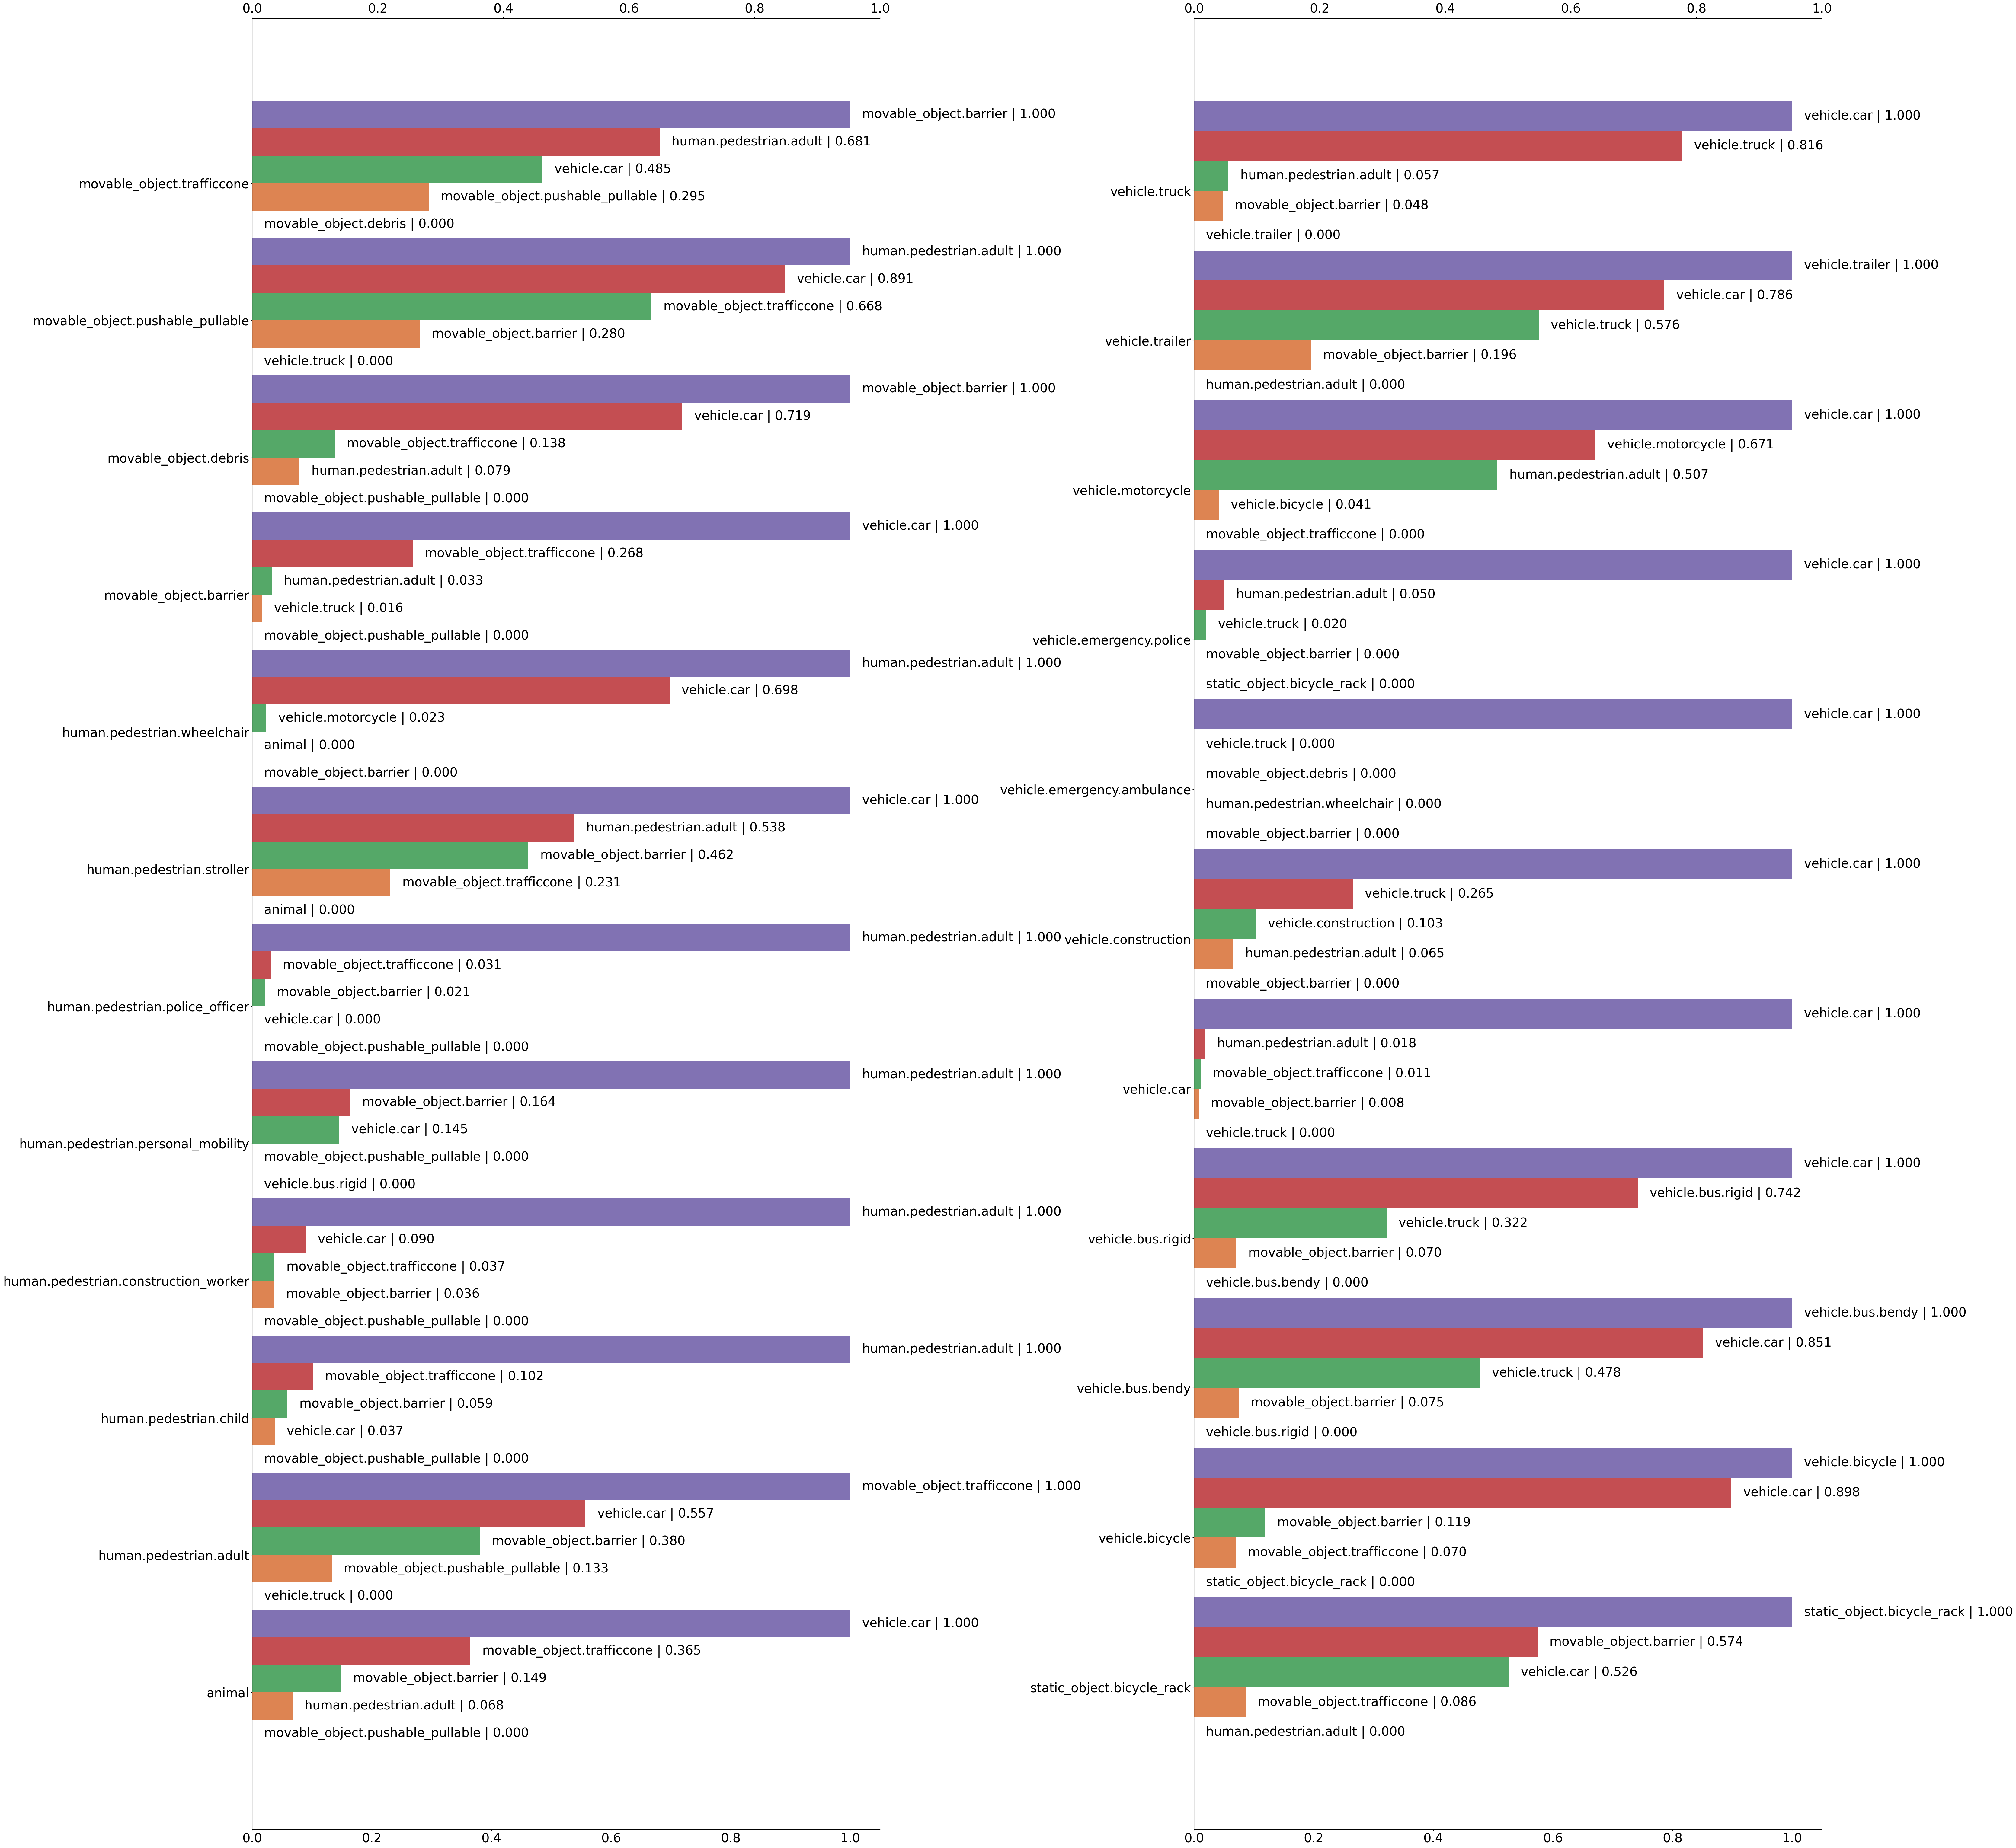

In [8]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,75))


## How many top K classes for incorrect classification to display
num_incorrect_class_shown = 5

axis1.set_label(f"Per class top {num_incorrect_class_shown} most common misclassifications. Values normalized normalized between top 5.")

plt.xticks(rotation=0)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2.7,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.6)

        

split_array = np.array_split(pred_numpy,2)
generate_subplot(axis=axis1,preds=split_array[0], labels = int_labels[:len(split_array[0])], num_incorrect_class_shown=num_incorrect_class_shown,  int_labels=int_labels)
generate_subplot(axis=axis2, preds= split_array[1], labels = int_labels[len(split_array[0]):len(split_array[0])+len(split_array[1])], num_incorrect_class_shown=num_incorrect_class_shown, int_labels=int_labels)
plt.savefig(
    fname=f"{project_root}/plots/dataset_23_misclassification.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_23_misclassification.svg",
     bbox_inches = 'tight'
)

In [9]:
reduced_int_labels, reduced_label_map = get_label_arr_and_map(
    torch_features=4
)


reduced_resnet_model = get_trained_resnet_model(
    layers=101,
    out_features=4,
    weight_str=f"{project_root}/weights/classifiers/second_iteration.pt"
)

if torch.cuda.is_available():
    reduced_resnet_model = reduced_resnet_model.cuda()

In [10]:
reduced_benign_data = gen_classification_tvt_dict(
    data_root=f"{large_root}",
    batch_size=dataset_batch_size,
    should_shuffle_datasets=False,
    transforms=img_transforms,
)

In [11]:
reduced_eval_dataset = reduced_benign_data.test
reduced_resnet_model.eval()
reduced_report = EasyDict(nb_test=0, correct=0)
reduced_predictions = torch.zeros(4,4)

#x_r = x_reduced, y_r = y_reduced
for x_r, y_r in tqdm(reduced_eval_dataset, position=0,leave=True):
    with torch.no_grad():
        x_r, y_r = x_r.to(device), y_r.to(device)
        reduced_preds = torch.argmax(reduced_resnet_model(x_r),dim=1)
        
        for p_r, gt_r in zip(reduced_preds, y_r):
            reduced_predictions[gt_r.item()][p_r.item()] += 1

100%|██████████| 720/720 [01:55<00:00,  6.25it/s]


In [12]:
plt.rcParams.update({'font.size': 10, "font.weight":"normal"})

def generate_4_subplot(axis, preds,labels,num_incorrect_class_shown,int_labels ):

    ax2 = axis.twiny()
    
    predictions = np.copy(preds)
    
    predictions = np.array([
        (x/x.sum())*100 for x in predictions
    ])

    ## Sets the number of predictions of itself to zero. 
    np.fill_diagonal(predictions,0)
    
    ## Gets the index of the top K misclassified classes for each of the 4 classes.
    top_k_inc_preds_index = np.array([np.argpartition(x, -num_incorrect_class_shown)[-num_incorrect_class_shown:] for x in predictions])



    bar_width = 0.7
    bar_y_coords = range(0,3*len(predictions),3)
    axis.set_yticks(
        [x+2*bar_width for x in bar_y_coords],
        labels=labels
        )



    def norm_data(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    axis.spines["right"].set_visible(False)
    ax2.spines["right"].set_visible(False)


    summed_top_k_inc = np.array([
        
        predictions[i][index] for i,index in 
        enumerate([lst for lst in top_k_inc_preds_index])
        ])
    

    normalized_top_k_inc = np.array([norm_data(x) for x in summed_top_k_inc])

    arr1inds = normalized_top_k_inc.argsort()


    normalized_top_k_inc = np.array([x[inds[::]] for x,inds in zip(normalized_top_k_inc,arr1inds) ])
    top_k_inc_preds_index = np.array([x[inds[::]] for x,inds in zip(top_k_inc_preds_index,arr1inds) ])

    for i, inc_pred_indexes in enumerate(top_k_inc_preds_index.T):
        
        transposed_normalized_incorrect = normalized_top_k_inc.T[i]
        inc_bar = axis.barh(
            y=[x+i*bar_width+bar_width/2 for x in bar_y_coords],
            width=[x for x in summed_top_k_inc.T[i]],
            height=bar_width,
            align="edge",
        )
        
        axis.bar_label(
        container=inc_bar,
        labels=[f"   {int_labels[x]} | {y:.3f}% of all instances" for x,y in zip(inc_pred_indexes,summed_top_k_inc.T[i])],
        label_type="edge"
        
    )
        
    axis.set_xlim(
    left=0,
    right=100
    )
    
    ax2.set_xlim(
    left=0,
    right=100
    )

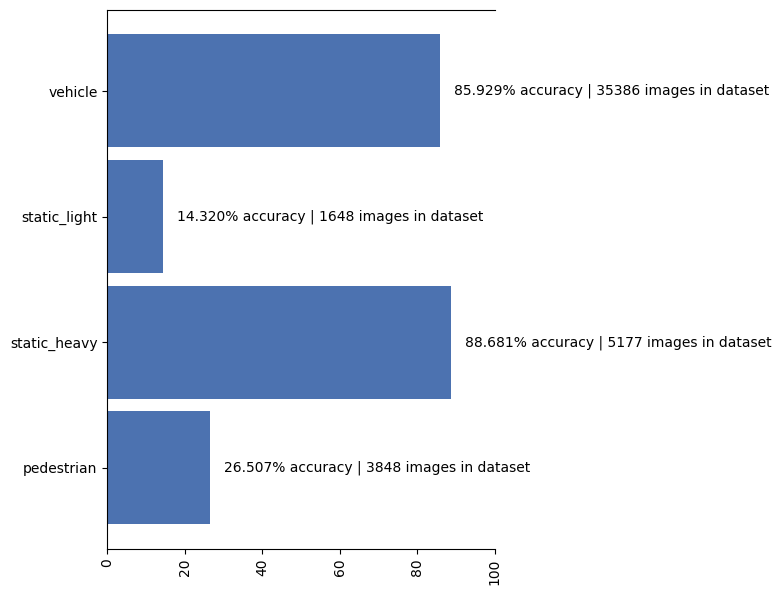

In [13]:
red_fig, red_ax = plt.subplots(figsize=(5,7))

plt.xticks(rotation=90)

red_pred_numpy = reduced_predictions.numpy()

red_sum_preds = red_pred_numpy.sum(axis=1)

red_self_preds = np.array([x[i] for i,x in zip(range(0,5),red_pred_numpy)])

red_acc_preds = np.divide(red_self_preds,red_sum_preds)*100

bar_width = 1.8
red_bar_y_coords = range(0,8,2)
red_ax.set_yticks(
    red_bar_y_coords,
    labels=reduced_int_labels
    )

red_acc_bar = red_ax.barh(
    y=[x-bar_width/2 for x in red_bar_y_coords],
    width=[x for x in  red_acc_preds],
    height=bar_width,
    align="edge",
    
)

red_ax.bar_label(
    container=red_acc_bar,
    labels=["%.3f%% accuracy | %g images in dataset" % (x, samples) for x,samples in zip(red_acc_preds,red_sum_preds)],
    label_type="edge",
    padding=10
    
)

red_ax.spines["right"].set_visible(False)

red_ax.set_xlim(
    0,100
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_4_accuracy.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_4_accuracy.svg",
     bbox_inches = 'tight'
)

print()

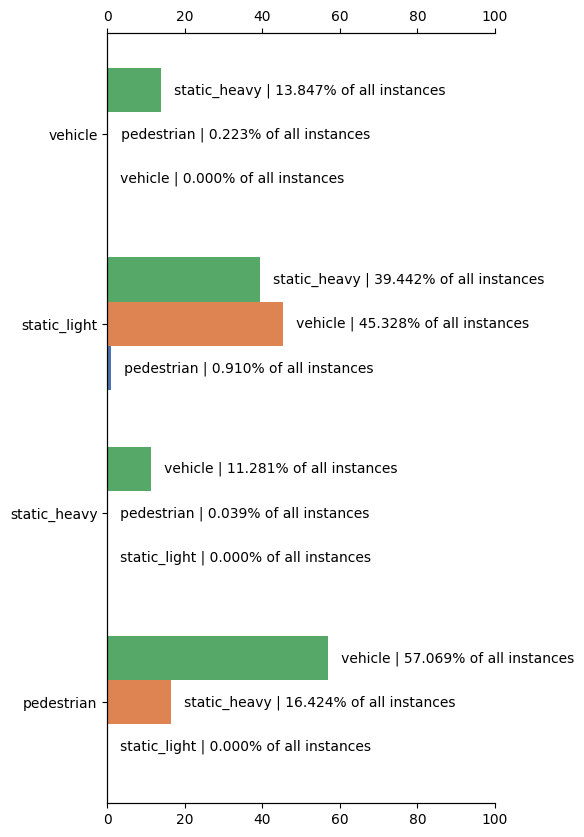

In [14]:

red_misclass_fig, axis_4 = plt.subplots(1,1,figsize=(5,10))

## How many top K classes for incorrect classification to display
num_incorrect_class_shown_4 = 3


axis_4.set_label(f"Per class top {num_incorrect_class_shown_4} most common misclassifications. Values normalized normalized between top 5.")


plt.xticks(rotation=0)

generate_4_subplot(
    axis=axis_4,
    labels=reduced_int_labels,
    preds=red_pred_numpy,
    num_incorrect_class_shown=num_incorrect_class_shown_4,
    int_labels=reduced_int_labels
)

plt.savefig(
    fname=f"{project_root}/plots/dataset_4_misclassification.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_4_misclassification.svg",
     bbox_inches = 'tight'
)

#### NB: It has been noted that at times, the 'gen_classification_tvt_dict' has crashed here. This is fixed by just restarting the notebook.

In [15]:
three_int_labels, three_label_map = get_label_arr_and_map(
    torch_features=3
)

three_resnet_model = get_trained_resnet_model(
    layers=101,
    out_features=3,
    weight_str=f"{project_root}/weights/classifiers/third_iteration.pt"
)

if torch.cuda.is_available():
    three_resnet_model = three_resnet_model.cuda()

three_benign_data = gen_classification_tvt_dict(
    data_root=f"{three_root}/",
    batch_size=dataset_batch_size,
    should_shuffle_datasets=True,
    transforms=img_transforms,
)

In [16]:
np.set_printoptions(suppress=True)
three_eval_dataset = three_benign_data.test
three_resnet_model.eval()
three_report = EasyDict(nb_test=0, correct=0)
three_predictions = []

for x_t, y_t in tqdm(three_eval_dataset, position=0,leave=True):
    with torch.no_grad():
        x_t, y_t = x_t.to(device), y_t.to(device)
        three_preds = torch.sigmoid(three_resnet_model(x_t))
        for p_t, gt_t in zip(three_preds, y_t):
            prediction_index = torch.argmax(p_t)
            prediction = p_t[prediction_index]
            three_predictions.append((prediction.item(),gt_t.item(), prediction_index.item()))

100%|██████████| 1579/1579 [04:14<00:00,  6.21it/s]


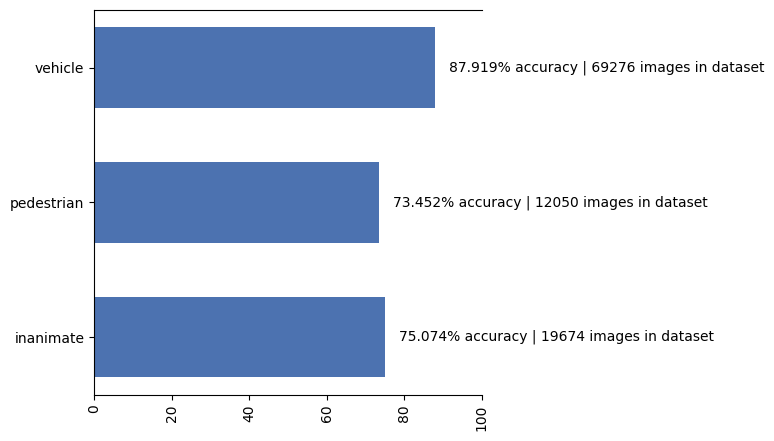

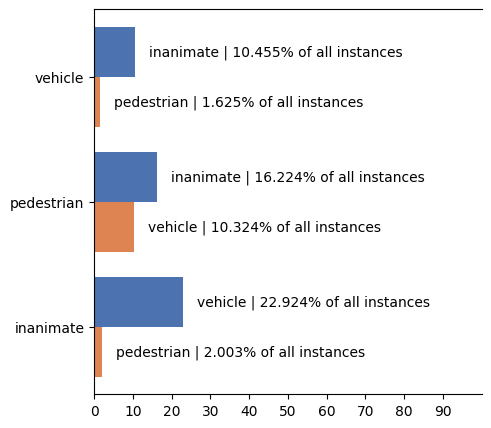

In [17]:

three_fig, three_ax = plt.subplots(figsize=(5,5))


plt.xticks(rotation=90)

three_pred_numpy = np.array(three_predictions)

inanimate_preds = np.array([(pred,gt,index) for pred,gt,index in three_predictions if gt == 0])
pedestrian_preds = np.array([(pred,gt,index) for pred,gt,index in three_predictions if gt == 1])
vehicle_preds = np.array([(pred,gt,index) for pred,gt,index in three_predictions if gt == 2])

three_sum_preds = np.array([len(inanimate_preds),len(pedestrian_preds),len(vehicle_preds)])

total_num_samples = sum(three_sum_preds)

inanimate_acc = np.divide(len([(pred,gt,index) for pred,gt,index in inanimate_preds if index ==0]),three_sum_preds[0])*100
pedestrian_acc = np.divide(len([(pred,gt,index) for pred,gt,index in pedestrian_preds if index ==1]),three_sum_preds[1])*100
vehicle_acc = np.divide(len([(pred,gt,index) for pred,gt,index in vehicle_preds if index ==2]),three_sum_preds[2])*100


three_acc_preds = [inanimate_acc, pedestrian_acc, vehicle_acc]
bar_width = 0.15
three_bar_y_coords = range(0,3,1)
three_ax.set_yticks(
    [x/4 for x in three_bar_y_coords],
    labels=three_int_labels
    )


three_acc_bar = three_ax.barh(
    y=[x/4-bar_width/2 for x in three_bar_y_coords],
    width=[x for x in  three_acc_preds],
    height=bar_width,
    align="edge",
    
)

three_ax.bar_label( 
    container=three_acc_bar,
    labels=["%.3f%% accuracy | %g images in dataset" % (x, samples) for x,samples in zip(three_acc_preds,three_sum_preds)],
    label_type="edge",
    padding=10
    
)

three_ax.spines["right"].set_visible(False)

three_ax.set_xlim(
    0,100
)

plt.savefig(
    fname=f"{project_root}/plots/dataset_3_unbalanced_performance.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_3_unbalanced_performance.svg",
     bbox_inches = 'tight'
)

plt.show()


bar_width = 0.4

misclass_fig, misclass_ax = plt.subplots(figsize=(5,5))

misclass_ax.set_yticks(
    [x+bar_width for x in three_bar_y_coords],
    labels=three_int_labels
)

inanimate_misclass = [0, len([index for _,_,index in inanimate_preds if index == 1]), len([index for _,_,index in inanimate_preds if index == 2])]
pedestrian_misclass = [len([index for _,_,index in pedestrian_preds if index == 0]), 0, len([index for _,_,index in pedestrian_preds if index == 2])]
vehicle_misclass = [len([index for _,_,index in vehicle_preds if index == 0]), len([index for _,_,index in vehicle_preds if index == 1]), 0]

def get_misclass_class(misclass_list, num_in_list, self_class):
    inanimate_preds = len([index for _,_,index in misclass_list if index == 0])
    pedestrian_preds = len([index for _,_,index in misclass_list if index == 1])
    vehicle_preds = len([index for _,_,index in misclass_list if index == 2])

    misclass_preds_list = [inanimate_preds, pedestrian_preds, vehicle_preds]
    misclass_preds_list[self_class] = 0

    sorted_list = sorted(misclass_preds_list, reverse=True)
    num_index = misclass_preds_list.index(sorted_list[num_in_list])

    misclass_percentage = (misclass_preds_list[num_index] / (inanimate_preds + pedestrian_preds + vehicle_preds)) * 100
    return misclass_preds_list[num_index], num_index, misclass_percentage

misclass_bar = misclass_ax.barh(
    y=[x+bar_width for x in three_bar_y_coords],
    width=[z for _,_,z in [get_misclass_class(inanimate_preds, 0, 0), get_misclass_class(pedestrian_preds, 0, 1), get_misclass_class(vehicle_preds, 0, 2)]],
    height=bar_width,
    align="edge",
)

misclass_bar_2 = misclass_ax.barh(
    y=[x for x in three_bar_y_coords],
    width=[z for _,_,z in [get_misclass_class(inanimate_preds, 1, 0), get_misclass_class(pedestrian_preds, 1, 1), get_misclass_class(vehicle_preds, 1, 2)]],
    height=bar_width,
    align="edge",
)

misclass_ax.set_xlim(left=0, right=100)

misclass_ax.set_xticks(range(0, 100, 10))


misclass_ax.spines["right"].set_visible(False)

misclass_ax.bar_label( 
    container=misclass_bar,
    labels=[f"{three_int_labels[y]} | {z:.3f}% of all instances" for x,y,z in [get_misclass_class(inanimate_preds, 0, 0), get_misclass_class(pedestrian_preds, 0, 1), get_misclass_class(vehicle_preds, 0, 2)]],
    label_type="edge",
    padding=10
)

misclass_ax.bar_label( 
    container=misclass_bar_2,
    labels=[f"{three_int_labels[y]} | {z:.3f}% of all instances" for x,y,z in [get_misclass_class(inanimate_preds, 1, 0), get_misclass_class(pedestrian_preds, 1, 1), get_misclass_class(vehicle_preds, 1, 2)]],
    label_type="edge",
    padding=10
)


plt.savefig(
    fname=f"{project_root}/plots/dataset_3_unbalanced_misclassification.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_3_unbalanced_misclassification.svg",
     bbox_inches = 'tight'
)
plt.show()


In [18]:
three_int_labels, three_label_map = get_label_arr_and_map(
    torch_features=3
)
img_transforms = transforms.Compose([
    transforms.Resize(resnet_im_size),
    transforms.ToTensor(),
    transforms.Normalize((0.3508, 0.3417, 0.3297), (0.1940, 0.1827, 0.1838)),
    ])

three_resnet_model = get_trained_resnet_model(
    layers=101,
    out_features=3,
    weight_str=f"{project_root}/weights/classifiers/final_iteration.pt"
)

if torch.cuda.is_available():
    three_resnet_model = three_resnet_model.cuda()

three_benign_data = gen_classification_tvt_dict(
    data_root=f"{fifty_root}/",
    batch_size=dataset_batch_size,
    should_shuffle_datasets=True,
    transforms=img_transforms,
    

)

In [19]:
np.set_printoptions(suppress=True)
three_eval_dataset = three_benign_data.test
three_resnet_model.eval()
three_report = EasyDict(nb_test=0, correct=0)
three_predictions = []

for x_t, y_t in tqdm(three_eval_dataset, position=0,leave=True):
    with torch.no_grad():
        x_t, y_t = x_t.to(device), y_t.to(device)
        three_preds = torch.sigmoid(three_resnet_model(x_t))
        for p_t, gt_t in zip(three_preds, y_t):
            prediction_index = torch.argmax(p_t)
            prediction = p_t[prediction_index]
            three_predictions.append((prediction.item(),gt_t.item(), prediction_index.item()))

100%|██████████| 481/481 [01:17<00:00,  6.18it/s]


In [20]:
resnet_three_report = gen_easydict()

for pred in three_predictions:
    write_to_easydict(
                easydict=resnet_three_report,
                prediction=pred[2],
                ground_truth=pred[1],
                float_prediction=pred[0]
            )

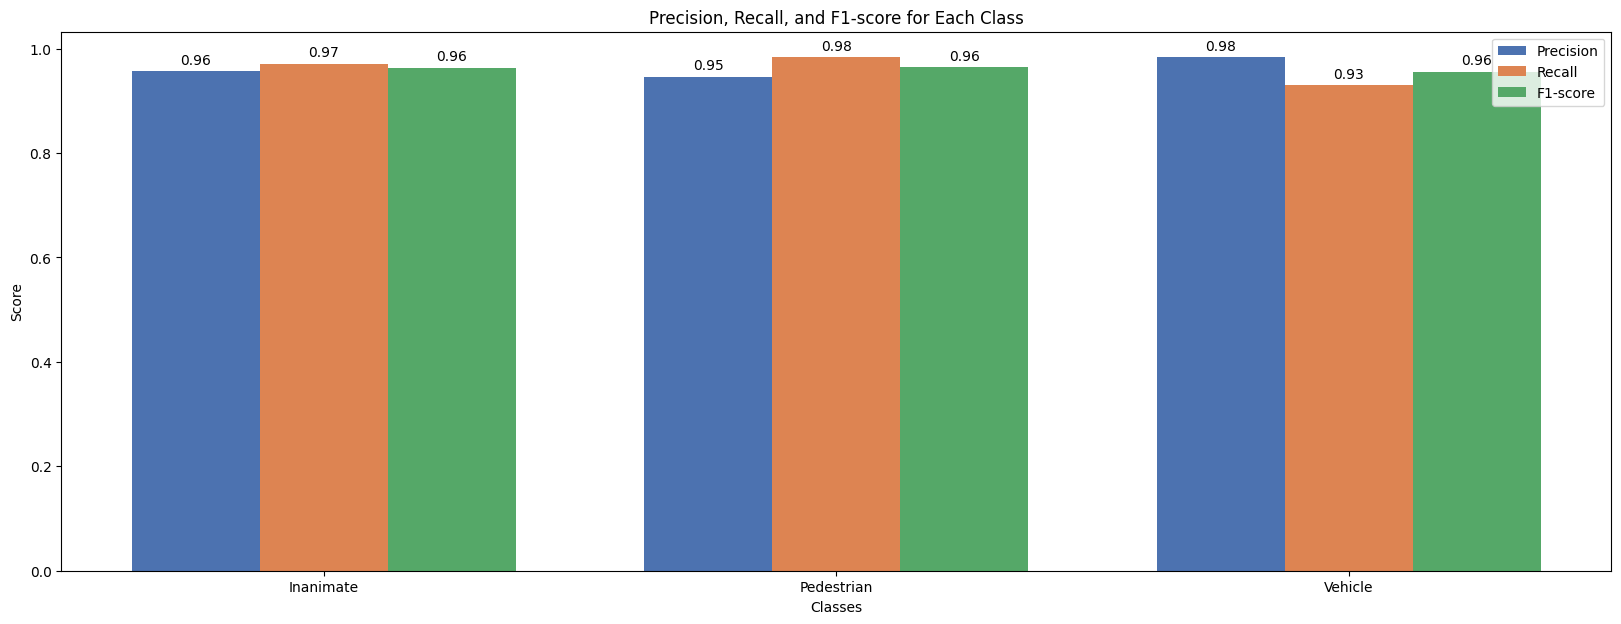

In [21]:


# Unzip the three_predictions list
predictions, ground_truths, prediction_indices = zip(*three_predictions)

# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(ground_truths, prediction_indices, average=None)

# Set up the plot
fig, ax = plt.subplots(figsize=(20,7))

# Set up the bar width
bar_width = 0.25

# Create the bar positions for each class
class_indices = range(len(set(ground_truths)))
precision_positions = [i - bar_width for i in class_indices]
recall_positions = class_indices
f1_score_positions = [i + bar_width for i in class_indices]

# Define the autolabel function
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot the bars and apply autolabel
precision_bars = ax.bar(precision_positions, precision, width=bar_width, label='Precision')
autolabel(precision_bars)

recall_bars = ax.bar(recall_positions, recall, width=bar_width, label='Recall')
autolabel(recall_bars)

f1_score_bars = ax.bar(f1_score_positions, f1_score, width=bar_width, label='F1-score')
autolabel(f1_score_bars)

# Set the x-axis labels and the legend
ax.set_xticks(class_indices)
ax.set_xticklabels(["Inanimate", "Pedestrian","Vehicle"])
ax.legend()

# Set the title and axis labels
ax.set_title('Precision, Recall, and F1-score for Each Class')
ax.set_xlabel('Classes')
ax.set_ylabel('Score')

# Show the plot

plt.savefig(
    fname=f"{project_root}/plots/dataset_3_performance.png",
     bbox_inches = 'tight'
)
plt.savefig(
    fname=f"{project_root}/plots/dataset_3_performance.svg",
     bbox_inches = 'tight'
)
plt.show()